In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Function to load and do basic exploration of a dataset
def load_and_explore(file_path, desc):
    print(f"\n{'='*80}")
    print(f"Exploring {desc} dataset: {file_path}")
    print(f"{'='*80}")
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Basic info
    print(f"\nDataset Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Check for missing values
    missing = df.isnull().sum().sum()
    print(f"\nTotal missing values: {missing}")
    
    # Display column info
    print("\nColumns information:")
    for col in df.columns[:10]:  # First 10 columns to avoid overwhelming output
        print(f"- {col}: {df[col].dtype}")
    
    if len(df.columns) > 10:
        print(f"... and {len(df.columns) - 10} more columns")
    
    return df

# Function to analyze time series data from Metro datasets
def analyze_time_series(df, description):
    print(f"\n{'='*80}")
    print(f"Time Series Analysis for {description}")
    print(f"{'='*80}")
    
    # Identify time-related columns and non-time columns
    time_cols = [col for col in df.columns if '-' in col]
    non_time_cols = [col for col in df.columns if '-' not in col]
    
    print(f"\nFound {len(time_cols)} time-related columns from {time_cols[0]} to {time_cols[-1]}")
    
    # Convert data to long format for time series analysis
    print("\nConverting to long format for time series analysis...")
    
    # Sample 5 regions for visualization
    top_regions = df.sort_values('SizeRank').head(5)
    
    # Create a long-format dataframe for the top regions
    long_df = pd.melt(
        top_regions, 
        id_vars=non_time_cols,
        value_vars=time_cols,
        var_name='Date',
        value_name='Value'
    )
    
    # Convert date strings to datetime
    long_df['Date'] = pd.to_datetime(long_df['Date'])
    
    # Plot time series for top 5 regions
    plt.figure(figsize=(14, 8))
    for region in top_regions['RegionName'].values:
        region_data = long_df[long_df['RegionName'] == region]
        plt.plot(region_data['Date'], region_data['Value'], linewidth=2, label=region)
    
    plt.title(f'{description} Over Time for Top 5 Regions by Size Rank', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"{description.replace(' ', '_')}_time_series.png")
    print(f"Time series plot saved as {description.replace(' ', '_')}_time_series.png")
    
    # Calculate year-over-year percentage changes
    print("\nCalculating year-over-year changes for recent periods...")
    
    # Get a sample of time columns one year apart
    recent_cols = time_cols[-13:]  # Last 13 months
    if len(recent_cols) >= 13:
        current = recent_cols[-1]
        year_ago = recent_cols[-13]
        
        # Calculate YoY change
        df['YoY_Change'] = ((df[current] - df[year_ago]) / df[year_ago] * 100)
        
        # Display top 5 regions with highest increase
        print("\nTop 5 regions with highest year-over-year increase:")
        top_increase = df.sort_values('YoY_Change', ascending=False).head(5)
        for _, row in top_increase.iterrows():
            print(f"- {row['RegionName']}, {row['StateName']}: {row['YoY_Change']:.2f}%")
        
        # Display top 5 regions with highest decrease
        print("\nTop 5 regions with highest year-over-year decrease:")
        top_decrease = df.sort_values('YoY_Change').head(5)
        for _, row in top_decrease.iterrows():
            print(f"- {row['RegionName']}, {row['StateName']}: {row['YoY_Change']:.2f}%")
    else:
        print("Not enough data for year-over-year comparison")

# Function to analyze migration data
def analyze_migration(df):
    print(f"\n{'='*80}")
    print("Analyzing California-Nashville Migration Data")
    print(f"{'='*80}")
    
    # Basic exploration
    print("\nUnique source datasets:")
    print(df['source_dataset'].unique())
    
    print("\nUnique geographies:")
    print(df['geography'].unique())
    
    print("\nUnique destinations:")
    print(df['destination'].unique())
    
    # Aggregate by geography and destination
    print("\nMigration counts by geography:")
    geo_counts = df.groupby(['geography', 'destination'])['inflow_count'].sum().reset_index()
    print(geo_counts)
    
    # Visualize migration counts
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    chart = sns.barplot(x='geography', y='inflow_count', hue='destination', data=geo_counts)
    
    plt.title('Migration Counts by Geography and Destination', fontsize=16)
    plt.xlabel('Source Geography', fontsize=14)
    plt.ylabel('Inflow Count', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Destination')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig("california_nashville_migration.png")
    print("Migration plot saved as california_nashville_migration.png")
    
    # If subgeography exists, analyze that too
    if 'subgeography' in df.columns and df['subgeography'].notna().any():
        print("\nTop subgeographies by migration count:")
        subgeo_counts = df.groupby(['subgeography', 'destination'])['inflow_count'].sum().reset_index()
        subgeo_counts = subgeo_counts.sort_values('inflow_count', ascending=False).head(10)
        print(subgeo_counts)
        
        # Visualize top subgeographies
        plt.figure(figsize=(14, 8))
        chart = sns.barplot(x='subgeography', y='inflow_count', hue='destination', data=subgeo_counts)
        plt.title('Top 10 Subgeographies by Migration Count', fontsize=16)
        plt.xlabel('Subgeography', fontsize=14)
        plt.ylabel('Inflow Count', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Destination')
        plt.tight_layout()
        
        # Save the plot
        plt.savefig("california_nashville_migration_subgeo.png")
        print("Subgeography migration plot saved as california_nashville_migration_subgeo.png")

# Function to analyze correlation between rent and home prices
def analyze_rent_price_correlation(rent_df, price_df, n_regions=5):
    print(f"\n{'='*80}")
    print("Analyzing Correlation Between Rent and Home Prices")
    print(f"{'='*80}")
    
    # Find common regions
    rent_regions = set(rent_df['RegionName'])
    price_regions = set(price_df['RegionName'])
    common_regions = rent_regions.intersection(price_regions)
    
    print(f"\nFound {len(common_regions)} common regions in both datasets")
    
    if len(common_regions) == 0:
        print("No common regions found for correlation analysis")
        return
    
    # Filter both dataframes to common regions and common time periods
    rent_cols = [col for col in rent_df.columns if '-' in col]
    price_cols = [col for col in price_df.columns if '-' in col]
    
    # Find common time periods
    common_time_cols = set(rent_cols).intersection(set(price_cols))
    
    if len(common_time_cols) == 0:
        print("No common time periods found for correlation analysis")
        return
    
    print(f"Found {len(common_time_cols)} common time periods in both datasets")
    
    # Get a list of common regions for analysis
    common_regions_list = list(common_regions)[:n_regions]
    
    # For each common region, calculate correlation over time
    correlations = []
    for region in common_regions_list:
        rent_region_data = rent_df[rent_df['RegionName'] == region]
        price_region_data = price_df[price_df['RegionName'] == region]
        
        if not rent_region_data.empty and not price_region_data.empty:
            rent_values = rent_region_data[list(common_time_cols)].values.flatten()
            price_values = price_region_data[list(common_time_cols)].values.flatten()
            
            # Filter out NaN values
            valid_indices = ~np.isnan(rent_values) & ~np.isnan(price_values)
            if sum(valid_indices) > 0:
                corr = np.corrcoef(rent_values[valid_indices], price_values[valid_indices])[0, 1]
                correlations.append((region, corr))
    
    if correlations:
        # Display the correlations
        print("\nCorrelations between rent and home prices for selected regions:")
        for region, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
            print(f"- {region}: {corr:.4f}")
            
        # Visualize for one example region
        example_region = correlations[0][0]
        rent_region_data = rent_df[rent_df['RegionName'] == example_region]
        price_region_data = price_df[price_df['RegionName'] == example_region]
        
        # Create normalized series for comparison
        rent_values = rent_region_data[list(common_time_cols)].values.flatten()
        price_values = price_region_data[list(common_time_cols)].values.flatten()
        
        # Normalize both series
        rent_norm = (rent_values - np.nanmean(rent_values)) / np.nanstd(rent_values)
        price_norm = (price_values - np.nanmean(price_values)) / np.nanstd(price_values)
        
        # Prepare data for plotting
        ts_data = pd.DataFrame({
            'Date': list(common_time_cols),
            'Normalized Rent': rent_norm,
            'Normalized Price': price_norm
        })
        ts_data['Date'] = pd.to_datetime(ts_data['Date'])
        ts_data = ts_data.sort_values('Date')
        
        # Plot
        plt.figure(figsize=(14, 8))
        plt.plot(ts_data['Date'], ts_data['Normalized Rent'], label='Normalized Rent', linewidth=2)
        plt.plot(ts_data['Date'], ts_data['Normalized Price'], label='Normalized Price', linewidth=2)
        
        plt.title(f'Normalized Rent vs Home Prices for {example_region}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Normalized Value', fontsize=14)
        plt.legend(fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save the plot
        plt.savefig("rent_price_correlation.png")
        print("Correlation plot saved as rent_price_correlation.png")
    else:
        print("Could not calculate meaningful correlations between the datasets")

# Main execution function



Exploring Zillow Observed Rent Index (ZORI) dataset: Metro_zori_uc_mfr_sm_month.csv

Dataset Shape: (493, 126)

First 5 rows:
   RegionID  SizeRank       RegionName RegionType StateName   2015-01-31  \
0    102001         0    United States    country       NaN  1184.433765   
1    394913         1     New York, NY        msa        NY  2209.959116   
2    753899         2  Los Angeles, CA        msa        CA  1684.237669   
3    394463         3      Chicago, IL        msa        IL  1366.441879   
4    394514         4       Dallas, TX        msa        TX  1024.638892   

    2015-02-28   2015-03-31   2015-04-30   2015-05-31  ...   2024-04-30  \
0  1192.066857  1203.327795  1211.905176  1221.884342  ...  1803.802156   
1  2222.416105  2240.139770  2261.896029  2281.226010  ...  3074.089411   
2  1698.879246  1717.164128  1735.013468  1745.047564  ...  2668.805218   
3  1374.358529  1383.294547  1389.968674  1400.122431  ...  1914.007894   
4  1021.852028  1025.955167  1039.659193 

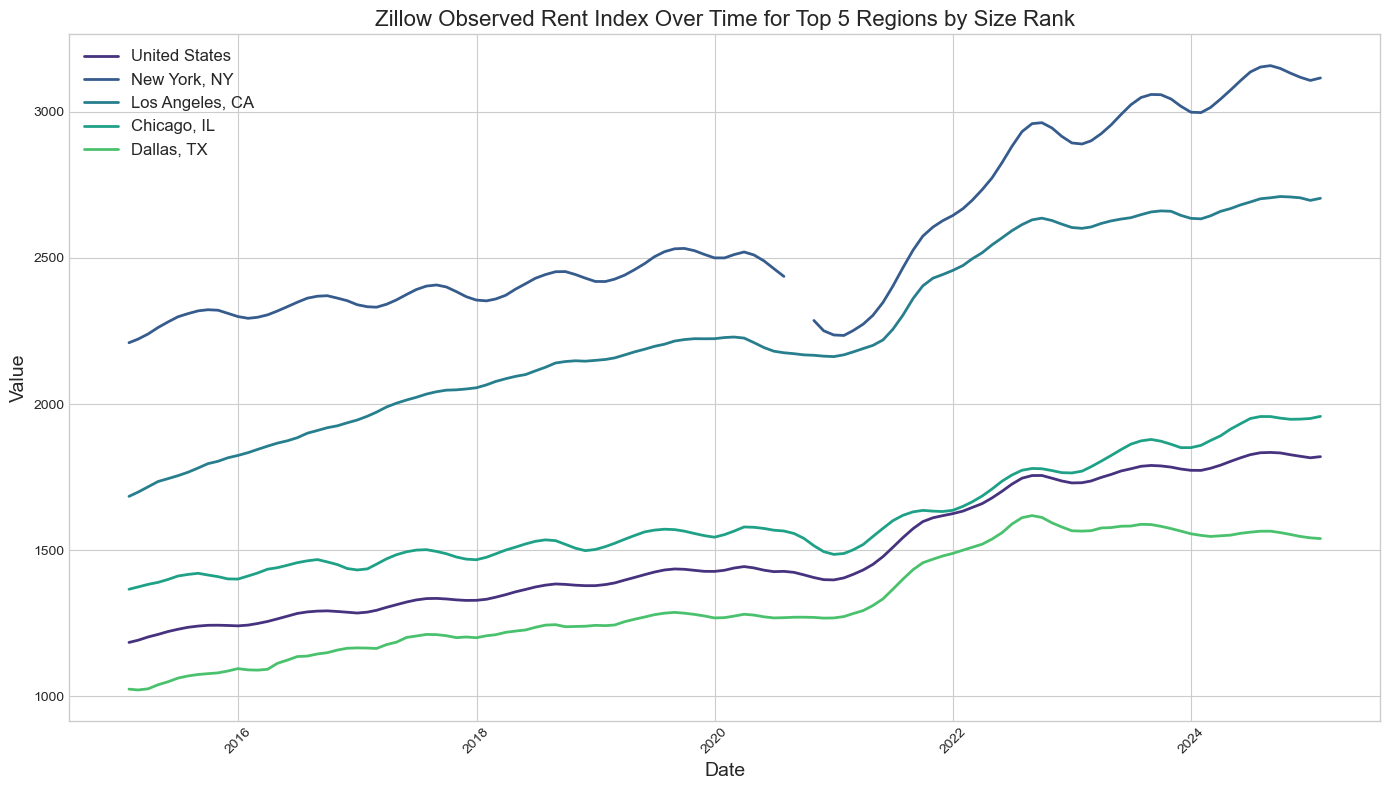

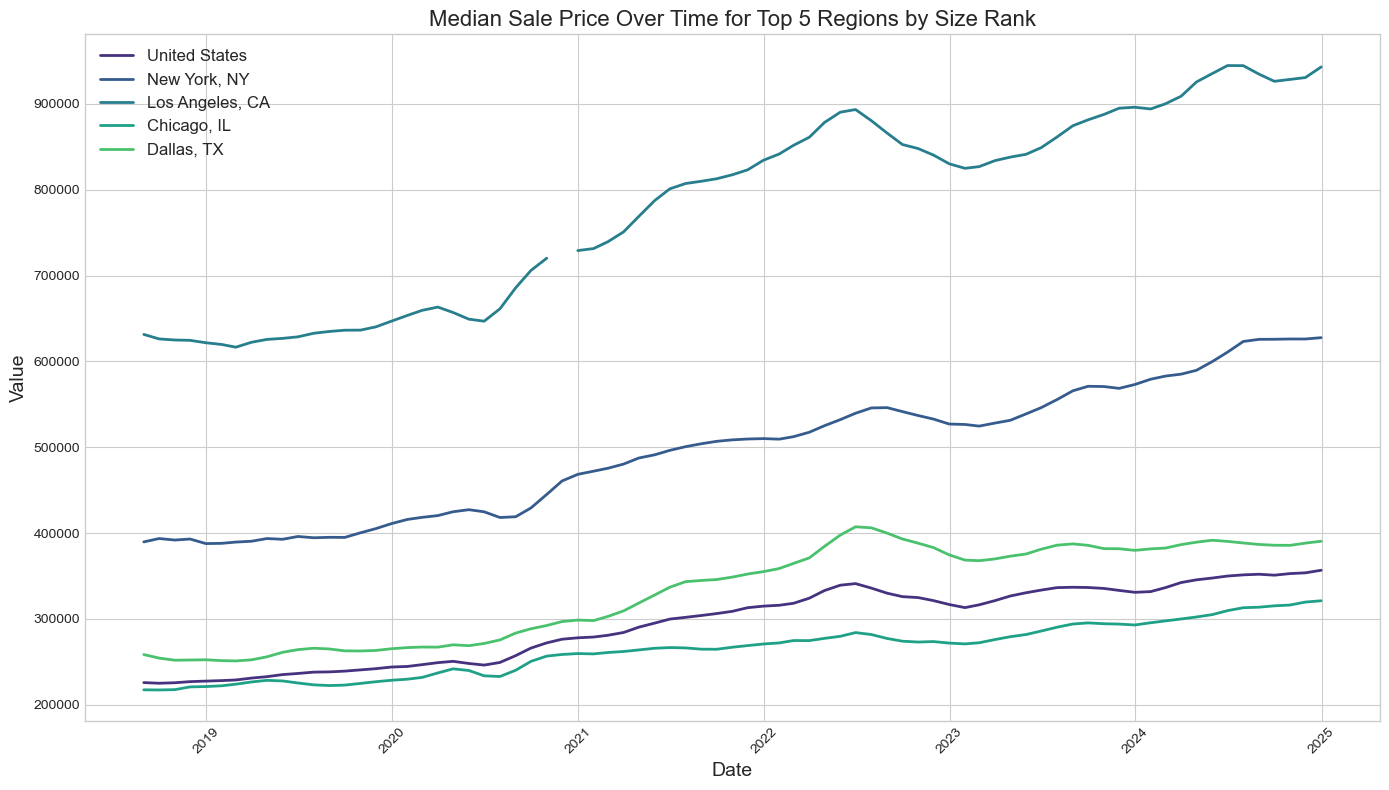

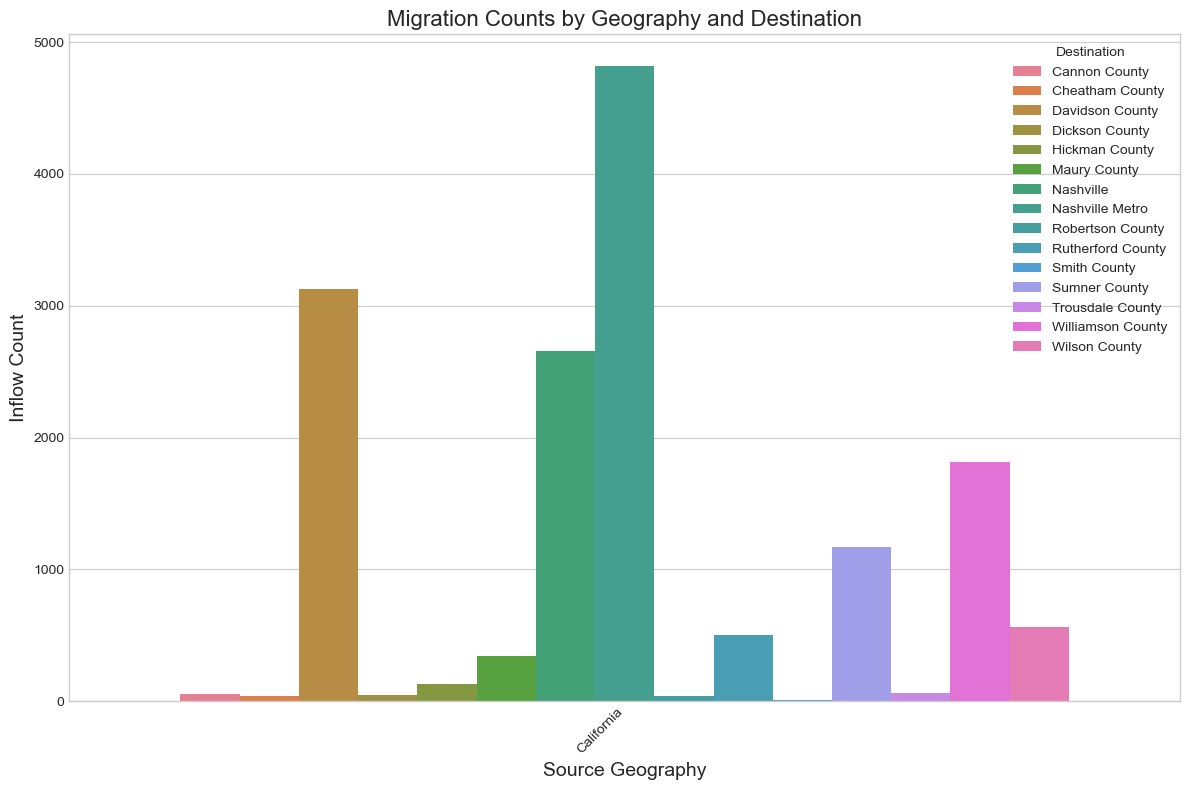

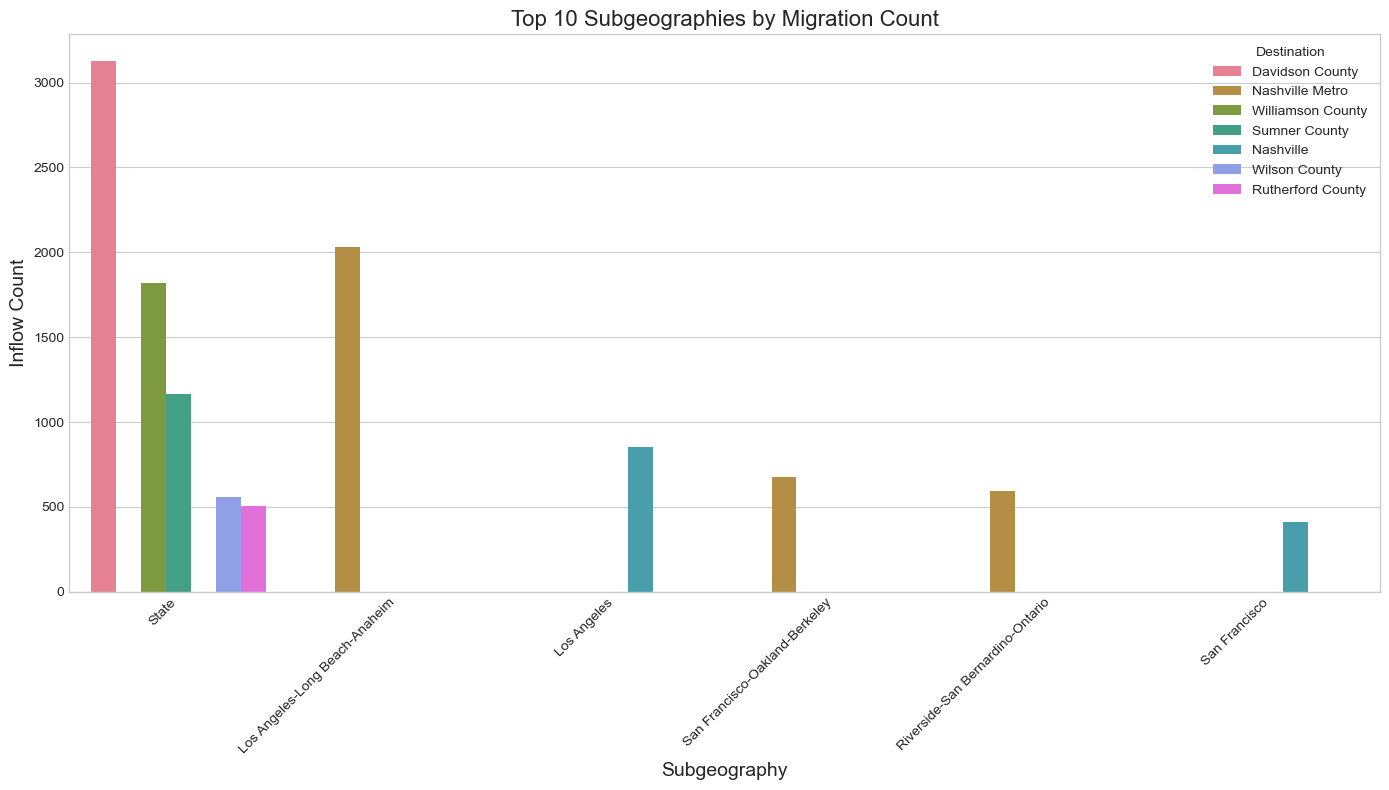

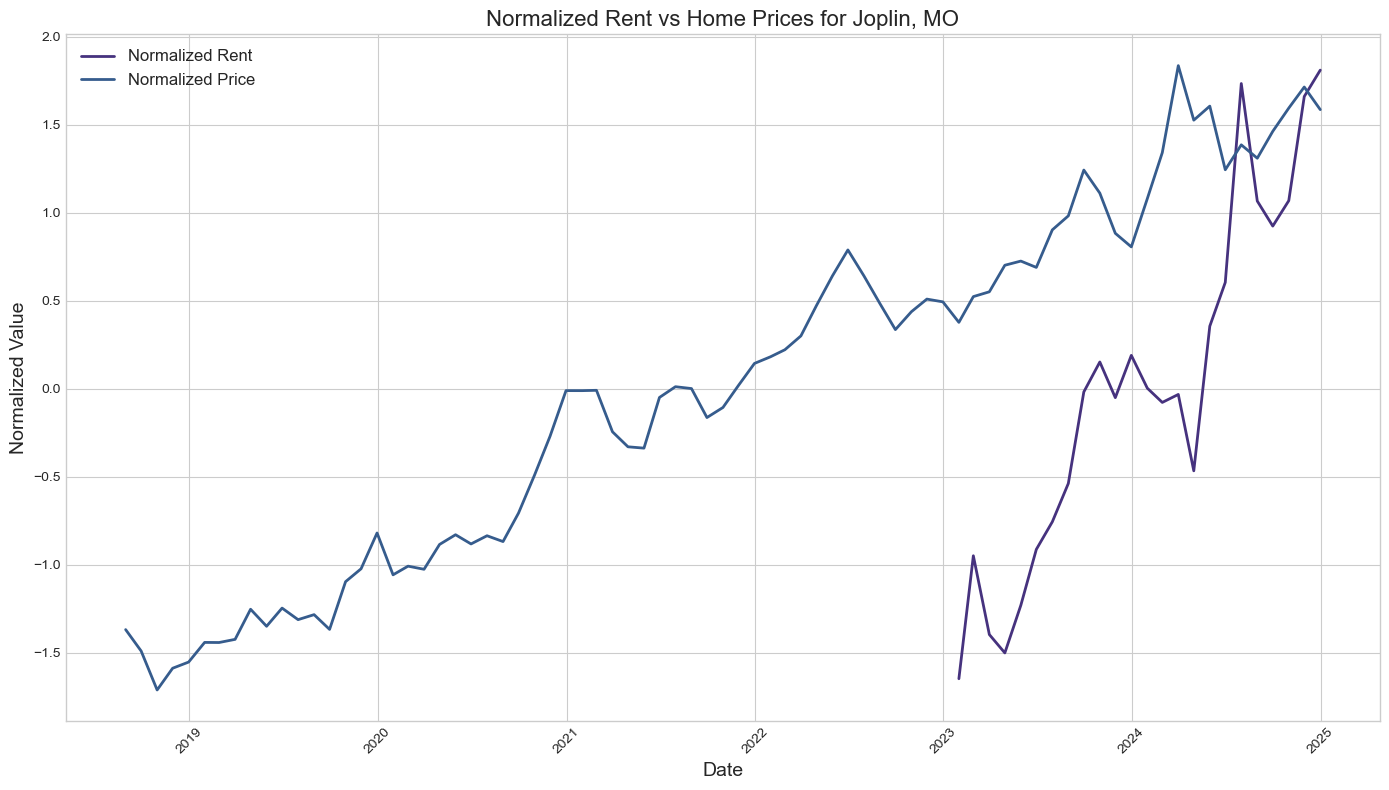

In [4]:
def main():
    # Load datasets
    rent_df = load_and_explore('Metro_zori_uc_mfr_sm_month.csv', 'Zillow Observed Rent Index (ZORI)')
    price_df = load_and_explore('Metro_median_sale_price_uc_sfrcondo_sm_sa_month.csv', 'Median Sale Price')
    migration_df = load_and_explore('california_nashville_migration_combined.csv', 'California-Nashville Migration')
    
    # Analyze time series data
    analyze_time_series(rent_df, 'Zillow Observed Rent Index')
    analyze_time_series(price_df, 'Median Sale Price')
    
    # Analyze migration data
    analyze_migration(migration_df)
    
    # Analyze correlation between rent and home prices
    analyze_rent_price_correlation(rent_df, price_df)
    
    print("\nExploratory Data Analysis complete!")

if __name__ == "__main__":
    main()